In [46]:
%load_ext autoreload
%autoreload 2

import math
import cmath
import numpy as np
import scipy
import sympy
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib import colors as m2colors
import seaborn as sns
from pylab import cm
import plotly
import plotly.graph_objects as go

import json
import os
import sys
import re
from datetime import datetime

from MMfxns import *
from MMplotting import *
from pyDOE2 import lhs

cwd = os.getcwd()
sns.set(style="ticks", font_scale=1.5)

mcolors = dict(m2colors.BASE_COLORS, **m2colors.CSS4_COLORS)

saveall = True

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

pd.set_option('display.expand_frame_repr', True, 'display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
dynamics = 'linear'
if dynamics == 'exp':
    fdir = './noise_results_mswitch/prod/'
elif dynamics == 'linear':
    fdir = './linear_noise_results_mswitch/prod/'
    
allfiles = os.listdir(fdir)
# print(allfiles)
labels = np.unique([int(i.split('_')[-1].split('.')[0]) for i in allfiles if '.csv' in i])
# print(labels)

alldf = pd.DataFrame()

for pi, pp in enumerate(labels):
    
    subdf = pd.read_csv(fdir + 'psweep_noise_trial_' + str(pp) + '.csv')
    subdf['label'] = pp
    alldf = pd.concat((alldf, subdf))

print(alldf.columns)
# print(alldf[['label', 'global_id', 'trial_id','mem_time','input_primetime']].loc[alldf['global_id']==0].tail(15))
print(len(alldf))
print('permanent', end = ' '); print(len(alldf.loc[alldf['mem_time'] < 0.]))
print('none', end = ' ');print(len(alldf.loc[alldf['mem_time'] == 0.]))
print('temporary', end = ' ');print(len(alldf.loc[alldf['mem_time'] > 0.]))
print('nan', end = ' ');print(len(alldf.loc[alldf['mem_time'].isna()]))

# print(alldf['mem_time'].max())
alldf.loc[alldf['mem_time'] < -0.05, 'mem_time'] = alldf['mem_time'].max() # 480.
alldf = alldf.reset_index(drop=True)
mem_grouping = alldf[['label', 'global_id', 'trial_id','mem_time','mem_stiff','prime_stiff','input_primetime']].groupby(['label', 'global_id', 'input_primetime']).agg('mean')

print(mem_grouping.head(10))
print(alldf['eps'])

Index(['Unnamed: 0', 'tau_F', 'tau_SG', 'tau_SR', 'kc', 'km', 'x0', 'a0',
       'xtt', 'g', 'n', 'm0', 'a_max', 'time_resolution', 'tau_R0', 'TV0SR',
       'TV0SG', 'dynamics', 'grid_resolution', 'eps', 'input_primetime',
       'global_id', 'mem_stiff', 'prime_stiff', 'mem_time',
       'result_prime_time', 'trial_id', 'label'],
      dtype='object')
172800
permanent 52890
none 104372
temporary 15538
nan 0
                                 trial_id    mem_time  mem_stiff  prime_stiff
label global_id input_primetime                                              
310   0         72                   49.5    0.000000        2.0         10.0
                168                  49.5    0.000000        2.0         10.0
                240                  49.5    0.000000        2.0         10.0
      1         72                   49.5    0.000000        2.0         10.0
                168                  49.5    0.000000        2.0         10.0
                240                  49.5

0.7056277056277057
0.546014705882353
   label  global_id    kscore        r2
0    926         34  0.705628  0.477659
   input_primetime  Unnamed: 0  tau_F      tau_SG      tau_SR        kc  \
0               72        49.5   12.0  188.974411  224.490714  1.512908   
1              168        49.5   12.0  188.974411  224.490714  1.512908   
2              240        49.5   12.0  188.974411  224.490714  1.512908   

         x0        a0  xtt         g         n        m0      a_max  \
0  1.933199  0.763165  0.0  32.87773  7.928974  5.531254  15.034161   
1  1.933199  0.763165  0.0  32.87773  7.928974  5.531254  15.034161   
2  1.933199  0.763165  0.0  32.87773  7.928974  5.531254  15.034161   

   time_resolution  tau_R0  TV0SR  TV0SG  grid_resolution  global_id  \
0              1.0     1.0    1.0    1.0            150.0       34.0   
1              1.0     1.0    1.0    1.0            150.0       34.0   
2              1.0     1.0    1.0    1.0            150.0       34.0   

   mem_s

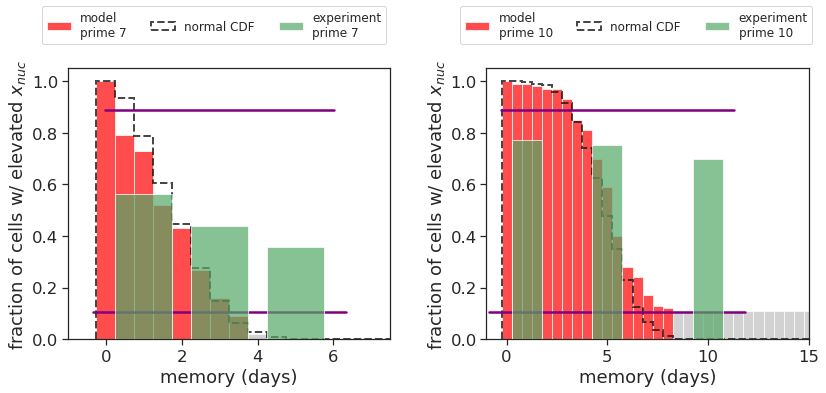

In [38]:
expdata = pd.read_excel('../experiments/bar_plot.xlsx')

fig, ax = plt.subplots(1,2,figsize=(12, 6))
ptime = [168, 240]
exp_distros = []
for xi, xx in enumerate(ptime):    
    
    subdata = expdata.loc[expdata['prime'].isin([0,xx])].copy(deep=True)
    subdata.at[subdata['type'] == 'soft', 'relaxation time'] = (xx/24+1*xx/24/2) * 24 # np.amax(bins * 24) + 3*24
    subdata.at[subdata['type'] == 'stiff', 'relaxation time'] = -1.5 * 24
#     print(subdata)
    
    distrodf = subdata.copy(deep=True).sort_values(by='relaxation time')
    distrodf.at[distrodf['type'] == 'soft', 'relaxation time'] = 480.
    distrodf.at[distrodf['type'] == 'stiff', 'relaxation time'] = 1.
    
    distrodf = distrodf.loc[distrodf['type'] != 'soft']
    distrodf = distrodf.loc[distrodf['type'] != 'stiff']
    ## interpolate
    
    for ti, tt in enumerate(np.arange(3)):
        add_df = pd.DataFrame(columns=distrodf.columns)#         
        add_df['relaxation time'] = np.diff(distrodf['relaxation time'].values)/2. + distrodf['relaxation time'].values[0:-1]
#         print(add_df)
        distrodf = distrodf.append(add_df).sort_values(by='relaxation time', ascending=True)
#         print(distrodf)
#         sys.exit()
        
        distrodf['YAP'] = distrodf['YAP'].interpolate(method='linear')
        distrodf['RUNX2'] = distrodf['RUNX2'].interpolate(method='linear')
        distrodf = distrodf.reset_index(drop=True)
#         print(distrodf)
        
#     print(distrodf)
    
    distrodf['mechanoact'] = (distrodf['YAP'] + distrodf['RUNX2']) / 2
    exp_distros.append([xx, distrodf[['mechanoact','relaxation time']].sort_values(by='relaxation time')])
    
    ax[xi].bar(subdata.loc[subdata['units']=='hr','relaxation time'] / 24, subdata.loc[subdata['units']=='hr','YAP']/100.,
           width=1.5, color='g', alpha=0.7, zorder=10, label = 'experiment\nprime '+str(int(xx/24.)))
#     ax[xi].bar(subdata.loc[subdata['units']=='control','relaxation time'] / 24, subdata.loc[subdata['units']=='control','YAP']/100.,
#            width=1.5, color='k', alpha=1., label='controls', zorder=10)
    
    val = subdata.loc[subdata['type'] == 'stiff','YAP'].values/100.
    ax[xi].plot(ax[xi].get_xlim(), [val, val], linewidth=2.5,color=mcolors['purple'])
    
    val = subdata.loc[subdata['type'] == 'soft','YAP'].values/100.
    ax[xi].plot(ax[xi].get_xlim(), [val, val], linewidth=2.5,color=mcolors['purple']) # linestyle='--'
    
    # exp distribution that gets used for the scoring
#     ax[xi].plot(distrodf['relaxation time']/24, distrodf['YAP']/100., color = mcolors['darkgreen'], linewidth=3.)
    
# print(exp_distros)

mem_grouping = (
    alldf[['label', 'global_id', 'trial_id','mem_time','mem_stiff',
           'prime_stiff', 'input_primetime']].groupby(['label', 'global_id', 'input_primetime'])
)

def get_reverse_cdf(x, bins):
    density, bins = np.histogram(x, bins=bins * 24., density=True) # 48 range=(0.1*24.,24.*24.)
    return 1. - np.cumsum(density) / np.amax(np.cumsum(density)), bins  #np.amax(np.cumsum(density)), bins # /np.amax(np.cumsum(density))

bins = np.arange(-0.25, 31., 0.5)
# print(bins)
output = mem_grouping[['mem_time']].apply(get_reverse_cdf, bins=bins)

mem_agged = mem_grouping.agg('mean').reset_index()
mem_agged['kscore'] = np.ones(len(mem_agged))
mem_agged['r2'] = np.zeros(len(mem_agged))

for oi, oo in enumerate(output):

    sub_exp = [i for i in exp_distros if i[0] == mem_agged.iloc[oi]['input_primetime']]

    if len(sub_exp) > 0:
        if np.isnan(oo[0]).any():
            print(mem_agged.iloc[oi])
            sys.exit()
            
        mask = oo[1] <= np.amax(sub_exp[0][1]['relaxation time'])
        oo_array = oo[0][mask[:-1]]
        oo_bins = oo[1][mask]
        r2list = []
        for si, ss in enumerate(sub_exp[0][1]['relaxation time']):
            ind = np.where(np.abs(oo_bins - ss) == np.amin(np.abs(oo_bins - ss)))[0][0]
            r2list.append(oo_array[ind])      
#         print(np.array(r2list))
        r2 = 1 - np.sum(np.sqrt((np.array(r2list) - sub_exp[0][1]['mechanoact']/100.)**2)) / len(r2list)
#         print(scipy.stats.pearsonr(np.array(r2list), sub_exp[0][1]['mechanoact']/100.))
#         np.correlate
        
        kscore = scipy.stats.kstest(oo_array, sub_exp[0][1]['mechanoact']/100.)  
        mem_agged.at[oi,'kscore'] = kscore.statistic
        mem_agged.at[oi,'r2'] = r2

metric = 'kscore' #'r2' # 'kscore'
if metric == 'kscore':
    order = True
else:
    order = False
mem_agged = mem_agged.sort_values(by=metric, ascending=order).reset_index(drop=True)
ranker = mem_agged[['label','global_id','kscore','r2']].groupby(['label','global_id']).agg('mean').sort_values(by=metric, ascending=order).reset_index()
print(ranker['kscore'].min())
# print(ranker['kscore'].max())
print(ranker['r2'].max())
# print(ranker['r2'].max())
rank = 0
print(ranker.iloc[[rank]])
# print(alldf.loc[alldf['label'] == ranker.iloc[rank]['label']].loc[alldf['global_id'] == ranker.iloc[rank]['global_id']].groupby(['input_primetime']).agg('mean'))
details = alldf.loc[alldf['label'] == ranker.iloc[rank]['label']].loc[alldf['global_id'] == ranker.iloc[rank]['global_id']].groupby(['input_primetime']).agg('mean')
# print(alldf.loc[alldf['label'] == ranker.iloc[rank]['label']].loc[alldf['global_id'] == ranker.iloc[rank]['global_id']][['input_primetime', 'eps']].reset_index(drop=True).iloc[[0]])
details = details.merge(alldf.loc[alldf['label'] == ranker.iloc[rank]['label']].loc[alldf['global_id'] == ranker.iloc[rank]['global_id']][['input_primetime', 'eps']].reset_index(drop=True).iloc[[0]], on='input_primetime', how='left')
print(details)

if dynamics == 'linear':
    bcolor = mcolors['red']
elif dynamics == 'exp':
    bcolor = mcolors['blue']

for xi, xx in enumerate(ptime):
    
    sub_agged = mem_agged.loc[mem_agged['label'] == ranker.iloc[rank]['label']].loc[mem_agged['global_id'] == ranker.iloc[rank]['global_id']]
    rankdf = alldf.merge(sub_agged, on=['label','global_id','input_primetime'],how='inner', suffixes=('','_y'))

    plotdf = rankdf.loc[rankdf['input_primetime'] == xx]
#     print(len(plotdf.loc[plotdf['mem_time'] == 0.]))
    
    # actual memory histogram (messes up tight_layout as-is)
#     fig2, ax2 = plt.subplots(1,1)
#     plotdf['mem_time'].hist(ax=ax2)
    
    n, bins, patches = ax[xi].hist(plotdf['mem_time'] / 24, density=True, cumulative=-1, 
                                   bins=bins, color=bcolor, alpha = 0.7, label='model\nprime '+str(int(xx/24.)), zorder=1);
    for pi, pp in enumerate(patches):
        if n[pi] == n[np.max(np.nonzero(n))]:
            pp.set_fc(mcolors['silver'])
    
    N = 1500
#     gausscompare = np.abs(np.random.normal(plotdf['mem_time'].mean()/24, plotdf['mem_time'].std()/24, N))
    gausscompare = np.abs(np.random.normal(plotdf.loc[plotdf['mem_time'] < plotdf['mem_time'].max(),'mem_time'].mean()/24, 
                                           plotdf.loc[plotdf['mem_time'] < plotdf['mem_time'].max(),'mem_time'].std()/24, N))
    ax[xi].hist(gausscompare, density=True, cumulative=-1, bins=bins, label='normal CDF',
                histtype='step', alpha=0.8, color='k', linewidth=2., linestyle='--')
    
    sub_exp = [i for i in exp_distros if i[0] == xx]
    ax[xi].set_xlim([-1., np.amax(sub_exp[0][1]['relaxation time'])*1.5/24])

    ax[xi].set_xlabel('memory (days)')
    ax[xi].set_ylabel('fraction of cells w/ elevated $x_{nuc}$')
    # print(mem_agged.head(20))
    ax[xi].legend(bbox_to_anchor=(-0.1, 1.25), loc='upper left', ncol=3, prop={"size":12})

plt.tight_layout()


# print(mem_agged[['label','global_id','kscore']].groupby(['label','global_id']).agg('mean').min())
# print(mem_agged[['label','global_id','kscore']].groupby(['label','global_id']).agg('mean').max())

# density, bins = ax[xi].hist(memory / 24, density=True, cumulative=-1, bins=bins, color='blue', alpha = 0.7, label='model');
# print(density)
# print(bins)

saveall = False
if saveall:
    now = datetime.now().strftime("%m-%d-%Y_%H.%M")    
    direc = os.getcwd() + '/../figures_v3/figure6/'
    fname1 = direc + "fig6_noise_" + dynamics + "_rank" + str(rank)+ "_v1." + now + ".png"
#     fig.tight_layout()
    fig.savefig(fname1, format='png', dpi=600, transparent=True)
    details.to_csv(direc + 'fig6_details_' + str(rank) + '_' + now + '.csv')

#     with open(fname1 + '.json', 'w') as f:
#         f.write(json.dumps(params))

128
    prime   type  primestiff  relaxstiff  relaxation time    units   YAP  RUNX2
0       0  stiff          10          10              -48  control  88.9   88.7
4       0   soft           2           2              384  control  10.6    3.0
8     240     hr          10           2               24       hr  77.3   64.3
9     240     hr          10           2              120       hr  75.3   56.0
10    240     hr          10           2              240       hr  69.7   62.7
2.061038442126514
4.897349840254641
0.12644902914571854


/home/ccprice/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


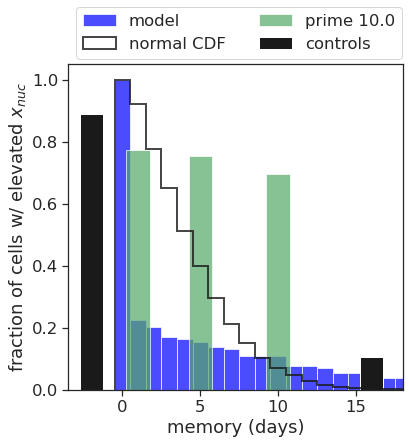

In [2]:
label = 671
ptime = 240
bins = np.arange(-0.5,30.,1.)

fig, ax = plt.subplots(1,1,figsize=(6,6))

# memory = np.load('../figures_v2/figure6_exp_fits/'+ str(ptime) +'.N127.npy')
memory = np.load('./noise_results_mswitch/'+ str(label) + '.P' + str(ptime) +'.N127.npy')
print(len(memory))
ax.hist(memory / 24, density=True, cumulative=-1, bins=bins, color='blue', alpha = 0.7, label='model');

expdata = pd.read_excel('../experiments/bar_plot.xlsx')

subdata = expdata.loc[expdata['prime'].isin([0,ptime])]
subdata.at[subdata['type'] == 'soft', 'relaxation time'] = 16 * 24 # np.amax(bins * 24) + 3*24
subdata.at[subdata['type'] == 'stiff', 'relaxation time'] = -2 * 24
print(subdata)

ax.bar(subdata.loc[subdata['units']=='hr','relaxation time'] / 24, subdata.loc[subdata['units']=='hr','YAP']/100.,
       width=1.5, color='g', alpha=0.7, label='prime '+str(ptime/24.))
ax.bar(subdata.loc[subdata['units']=='control','relaxation time'] / 24, subdata.loc[subdata['units']=='control','YAP']/100.,
       width=1.5, color='k', alpha=1., label='controls')
# plt.bar(subdata['relaxation time'] / 24, subdata['RUNX2']/100., color='r', alpha=0.7)

N = 1500
gausscompare = np.abs(np.random.normal(np.mean(memory/24), np.std(memory/24), N))
# gausscompare = np.random.normal(np.mean(memory/24), np.std(memory/24), N)
# gausscompare[gausscompare < 0.] = 0.
print(np.mean(memory/24))
print(np.std(memory/24))
print(np.std(memory/24)/np.sqrt(N))

ax.hist(gausscompare, density=True, cumulative=-1, bins=bins, label='normal CDF',
         histtype='step', alpha=0.8, color='k', linewidth=2.)

ax.set_xlim([-3.5,18])
ax.set_xlabel('memory (days)')
ax.set_ylabel('fraction of cells w/ elevated $x_{nuc}$')
ax.legend(bbox_to_anchor=(0, 1.2), loc='upper left', ncol=2)

128
   prime   type  primestiff  relaxstiff  relaxation time    units   YAP  RUNX2
0      0  stiff          10          10              -36  control  88.9   88.7
4      0   soft           2           2              192  control  10.6    3.0
5    168     hr          10           2               24       hr  56.3   31.7
6    168     hr          10           2               72       hr  44.0   30.0
7    168     hr          10           2              120       hr  35.7   12.7
2.811149403874814
5.0058616831695755
0.12925079288222396


/home/ccprice/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


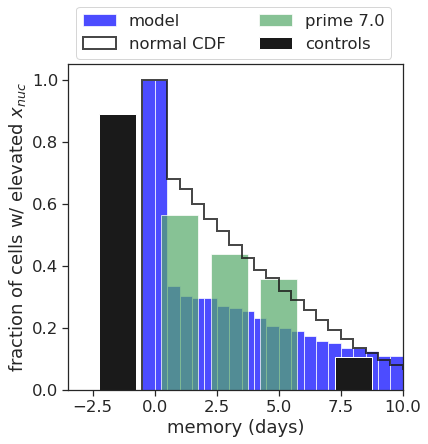

In [3]:
label = 21
ptime = 168
bins = np.arange(-0.5,20.,.5)

fig, ax = plt.subplots(1,1,figsize=(6,6))

# memory = np.load('../figures_v2/figure6_exp_fits/'+ str(ptime) +'.N127.npy') # '
memory = np.load('./noise_results_mswitch/'+ str(label) + '.P' + str(ptime) +'.N127.npy')
print(len(memory))
ax.hist(memory / 24, density=True, cumulative=-1, bins=bins, color='blue', alpha = 0.7, label='model');

expdata = pd.read_excel('../experiments/bar_plot.xlsx')

subdata = expdata.loc[expdata['prime'].isin([0,ptime])]
subdata.at[subdata['type'] == 'soft', 'relaxation time'] = 8*24 # np.amax(bins * 24) + 3*24
subdata.at[subdata['type'] == 'stiff', 'relaxation time'] = -1.5 * 24
print(subdata)

ax.bar(subdata.loc[subdata['units']=='hr','relaxation time'] / 24, subdata.loc[subdata['units']=='hr','YAP']/100.,
       width=1.5, color='g', alpha=0.7, label='prime '+str(ptime/24.))
ax.bar(subdata.loc[subdata['units']=='control','relaxation time'] / 24, subdata.loc[subdata['units']=='control','YAP']/100.,
       width=1.5, color='k', alpha=1., label='controls')
# plt.bar(subdata['relaxation time'] / 24, subdata['RUNX2']/100., color='r', alpha=0.7)

N = 1500
gausscompare = np.random.normal(np.mean(memory/24), np.std(memory/24), N)
gausscompare[gausscompare < 0.] = 0.
print(np.mean(memory/24))
print(np.std(memory/24))
print(np.std(memory/24)/np.sqrt(N))

ax.hist(gausscompare, density=True, cumulative=-1, bins=bins, label='normal CDF',
         histtype='step', alpha=0.8, color='k', linewidth=2)

ax.set_xlim([-3.5,10])
ax.set_xlabel('memory (days)')
ax.set_ylabel('fraction of cells w/ elevated $x_{nuc}$')
ax.legend(bbox_to_anchor=(0, 1.2), loc='upper left', ncol=2)

saveall = False
if saveall:
    direc = os.getcwd() + '/../figures_v3/figure6/'

    fname1 = direc + "exp_compare_P"+str(ptime)+"_L"+str(label)+".png"
    print(fname1)
    fig.tight_layout()
    fig.savefig(fname1, format='png', dpi=600, transparent=True)

In [ ]:
## figure 6
## data maps for parameters, static and Energy dependent.
## spearman correlation map
## heat map for priming time, memory time, distance from m_c.

# goal: assemble different inputs, get profiles, collocate summary_stats output, make a grid of the inputs and plot.
#(probably very sensitive)

direc = './stiff_results/staticTS/'
fname = 'static_LHS_SG_SR_ng'
# fname2 = 'static_LHS_SG_SR_n4'

allDF = pd.read_csv(direc + fname +'.csv')
# allDF2 = pd.read_csv(direc + fname2 +'.csv')
input_prof = np.load(direc + fname + '_inputs.npy', allow_pickle=True)
# input_prof2 = np.load(direc + fname2 + '_inputs.npy', allow_pickle=True)

# allDF = pd.concat((allDF, allDF2))

allDF = allDF.reset_index(drop=True)
print(allDF.head(1))
print(len(allDF))
# print(input_prof.shape)
# print(input_prof)
prettylabel = {
#                         'prime_time':'$t_{prime}$', 
                        'tau_SG':'${\\tau}_{SG}$', 
                        'tau_SR':'${\\tau}_{SR}$', 
                        # 'm0':'${m}_{0}$',
                        'tau':'${\\tau}$',
                        'delta_prime':'${\Delta}_{prime}$',
                        'delta_mem':'${\Delta}_{mem}$', 
                        'delta_tot':'${\Delta}_{tot}$',
                        'n':'n'
                        }

allDF['delta_prime'] = (allDF['prime_stiff'] - allDF['m_c'] * allDF['m0']) / allDF['m0']
allDF['delta_mem'] = (allDF['m_c'] * allDF['m0'] - allDF['mem_stiff']) / allDF['m0']
allDF['delta_tot'] = allDF['delta_prime'] + allDF['delta_mem']
allDF['tm_over_tp'] = allDF['mem_time'] / allDF['prime_time']

memDF = allDF.loc[allDF['mem_time'] > 0.].loc[allDF['mem_time'].notna()]

subcols = ['tau','tau_SG','tau_SR', 'delta_prime', 'delta_mem', 'delta_tot','n'] # 'm0','tau',
fig, ax = plt.subplots(1,1,figsize=(6, 6))

mem_corr = plot_memcorr(memDF, subcols, prettylabel, ax)
mem_corr = mem_corr.iloc[mem_corr.abs().argsort()]
heat_cols = mem_corr.index.values[-2:]
print(heat_cols)

heat_cols = ['delta_prime', 'tau_SG']
fig2 = plot_groupedDF_heatmap(memDF[subcols + ['tm_over_tp']], heat_cols, prettylabel, [None, [120, 400]])

fig2.show()

saveall = False
if saveall:
    direc = os.getcwd() + '/figures/figure6/'

    fname1 = direc + "staticNG_spearman_corrs_v1.png"
    print(fname1)
    fig.savefig(fname1, format='png', dpi=600)
    
    fname2 = direc + "static_heatmap_v1.png"
    fig2.write_image(fname2, scale = 1.5, engine='kaleido')
    

In [ ]:
## figure 6
## data maps for parameters, Energy DEPENDENT

direc = './stiff_results/dynamicTS/'
# fname = 'energy_dependent_LHS_n3'
fname = 'energy_dependent_LHS_ng_all'
# fname2 = 'energy_dependent_LHS_ng2'
# fname2 = 'static_paramtest_SG_SR_tautest_n4'

allDF = pd.read_csv(direc + fname +'.csv')
# allDF2 = pd.read_csv(direc + fname2 +'.csv')
input_prof = np.load(direc + fname + '_inputs.npy', allow_pickle=True)
# input_prof2 = np.load(direc + fname2 + '_inputs.npy', allow_pickle=True)

# allDF = pd.concat((allDF, allDF2))
# input_prof = np.concatenate((input_prof, input_prof2))

allDF = allDF.reset_index(drop=True)
print(allDF.head(1))
print(len(allDF))

# allDF.to_csv('energy_dependent_LHS_ng_all'+'.csv')
# np.save('energy_dependent_LHS_ng_all'+'_inputs.npy', input_prof)

# sys.exit()


prettylabel = {
                        #'prime_time':'$t_{prime}$', 
                        'tau_R0':'${\\tau}_{SGR}$', 
                        'TV0SG':'${V}_{SG}$',
                        'TV0SR':'${V}_{SR}$',
                        'm0':'${m}_{0}$',
                        'tau':'${\\tau}$',
                        'delta_prime':'${\Delta}_{prime}$',
                        'delta_mem':'${\Delta}_{mem}$', 
                        'delta_tot':'${\Delta}_{tot}$',
                        'n':'n'
                        }

allDF['delta_prime'] = (allDF['prime_stiff'] - allDF['m_c'] * allDF['m0']) / allDF['m0']
allDF['delta_mem'] = (allDF['m_c'] * allDF['m0'] - allDF['mem_stiff']) / allDF['m0']
allDF['delta_tot'] = allDF['delta_prime'] + allDF['delta_mem']
allDF['tm_over_tp'] = allDF['mem_time'] / allDF['prime_time']

# allDF.to_csv('./stiff_results/energy_dependent_LHS_ng_addcols.csv')
# sys.exit()

memDF = allDF.loc[allDF['mem_time'] > 0.].loc[allDF['mem_time'].notna()]

# memDF[subcols].apply(lambda x: x - x.mean()/x.std(), axis=0)

subcols = ['tau', 'tau_R0', 'TV0SG', 'TV0SR', 'delta_prime', 'delta_mem', 'delta_tot', 'n'] # 'm0','tau',
# subcols = ['tau', 'tau_R0', 'TV0SG', 'TV0SR', 'delta_prime', 'delta_mem', 'delta_tot']

# memDF[subcols + ['tm_over_tp']] = memDF[subcols + ['tm_over_tp']].apply(lambda x: x - x.mean()/x.std(), axis=0)

fig, ax = plt.subplots(1,1,figsize=(7, 6))
mem_corr = plot_memcorr(memDF, subcols, prettylabel, ax)
mem_corr = mem_corr.iloc[mem_corr.abs().argsort()]
heat_cols = mem_corr.index.values[-2:]
print(heat_cols)

heat_cols = ['TV0SG', 'tau_R0']
fig2 = plot_groupedDF_heatmap(memDF[subcols + ['tm_over_tp']], heat_cols, prettylabel, [None, [150,700]])

plt.show()
fig2.show()

saveall = False
if saveall:
    direc = os.getcwd() + '/figures/figure6/'

    fname1 = direc + "energyNG_spearman_corrs_v2.png"
    print(fname1)
    fig.savefig(fname1, format='png', dpi=600)
    
    fname2 = direc + "energyNG_heatmap_v2.png"
    fig2.write_image(fname2, scale = 1.5, engine='kaleido')

In [ ]:



## test cell for failures

failU = np.load('failureU2.npy', allow_pickle=True)

print(failU)

failU = failU[0:10000]

# print(failU[0:100])
fig, ax = plt.subplots(3, 1, figsize=(6,10))

ax[0].plot(np.arange(len(failU)-1), np.abs(np.diff(failU)))
ax[0].scatter(diff_algo, np.abs(np.diff(failU))[diff_algo])

print(argrelextrema(np.abs(np.diff(failU)), np.less)[0])
print(find_peaks(-np.abs(np.diff(failU)))[0])

diff_algo = find_peaks(-np.abs(np.diff(failU)))[0]
algo = find_peaks((-failU))[0]

ax[1].plot(np.arange(len(failU)), failU)
ax[1].scatter(diff_algo, failU[diff_algo])

ax[2].plot(np.arange(len(failU)), failU)
ax[2].scatter(algo, failU[algo])


params = {}
params['tau'] = 1.
params['m0'] = 6.
params['n'] = 3
params['type'] = 'stiff'

m = 3.
a = 1.192
xUd = np.linspace(0,3,int(1e6))

x_current = 0.73

U_data = U(f_m, m, xUd, a, params)

x_args = find_peaks(-np.abs(np.diff(U_data)))[0]
x_argmin = x_args[np.abs(xUd[x_args]-x_current) == np.amin(np.abs(xUd[x_args]-x_current))]

plt.plot(xUd, U_data)
plt.scatter(xUd[x_args], U_data[x_args])